# **Introduction to Deep Learning: Final Project**

**Submitted by:**

Roei Matz       205871478

Yotam Silverman 313532418

# Project Description

The data for this project was gathered from the [sign language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist) dataset from the website kaggle.com.


The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255.

Our project's objective is to design and build a neural network that will identify the letters given in each image.

In [99]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

# CapsNet related imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
# clone package repository
!git clone https://github.com/jindongwang/Pytorch-CapsuleNet.git

# navigate to directory
%cd Pytorch-CapsuleNet

# get modifications made on the repo
!git pull origin master

# import it
from capsnet import CapsNet
#

import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

Cloning into 'Pytorch-CapsuleNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 57 (delta 1), reused 3 (delta 1), pack-reused 49
Unpacking objects: 100% (57/57), done.
/content/Pytorch-CapsuleNet/Pytorch-CapsuleNet/Pytorch-CapsuleNet/Pytorch-CapsuleNet/Pytorch-CapsuleNet/Pytorch-CapsuleNet
From https://github.com/jindongwang/Pytorch-CapsuleNet
 * branch            master     -> FETCH_HEAD
Already up to date.


Mount Google Drive and load the project's data:

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')
train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
x_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,1:]
x_test = np.genfromtxt(test_csv, delimiter=',')[1:,1:]

train_csv = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_train.csv')
test_csv  = open('/content/gdrive/My Drive/Intro_to_Deep_Learning/sign_mnist_test.csv')
t_train_val = np.genfromtxt(train_csv, delimiter=',')[1:,0]
t_test =  np.genfromtxt(test_csv, delimiter=',')[1:,0]


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Spliting the train set to train and validation

In [16]:
x_train = x_train_val[0:round(0.8*len(x_train_val))]
x_val = x_train_val[round(0.8*len(x_train_val)):]

t_train = t_train_val[0:round(0.8*len(t_train_val))]
t_val = t_train_val[round(0.8*len(t_train_val)):]

Making a dictionary for the alphabet:

In [17]:
import string
alphabet_dict = dict(zip(range(0,26),string.ascii_uppercase))

print(alphabet_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


Here we show few examples of the letters notions in the sign language:

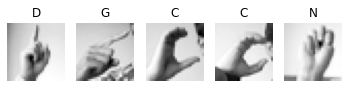

In [18]:
plt.figure(figsize=(6, 3))
for i in range(0,5): 
  plt.subplot(1, 5, i + 1)
  img = x_train[i]
  img = np.reshape(img, (28, 28))
  plt.imshow(img, cmap='Greys_r')
  plt.title(alphabet_dict[int(t_train[i])])
  plt.axis('off');

Normalizing the data set:

In [19]:
def img_norm(data):
  output = []
  for img in data: 
    img = (img - np.mean(img))/np.std(img)
    output.append(np.array(img))
  return np.array(output)

x_train_norm = img_norm(x_train)
x_val_norm = img_norm(x_val)
x_test_norm = img_norm(x_test)

In [20]:
train_loader = torch.utils.data.DataLoader(
    np.concatenate((t_train[:,None], x_train_norm),axis=1),
    batch_size=64, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    np.concatenate((t_val[:,None], x_val_norm),axis=1),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    np.concatenate((t_test[:,None], x_test_norm),axis=1),
    batch_size=64, shuffle=True)

Defining CNN

In [110]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

def get_accuracy(model, loader=train_loader):
    model.eval()
    loss = 0
    correct = 0
    pred_list = []
    true_list = []
    for ar in loader:
        data = ar[:,1:]
        label = ar[:,0]
        # send to device
        data, label = data.to(device), label.to(device)
        
        data = data.view(-1, 28*28)
        data = data.view(-1, 1, 28, 28)
        pred = model(data)
        loss += F.nll_loss(pred, label.long(), reduction='sum').item() # sum up batch loss                                                               
        pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()
 
        for y in pred.squeeze(1):
          pred_list.append(y)

        for y in label:  
          true_list.append(y)

    conf_mat = confusion_matrix(true_list, pred_list, labels=list(range(0,9))+list(range(10,25)))    
    loss /= len(loader.dataset)
    accuracy = 100. * correct / len(loader.dataset)
    
    return loss, accuracy, conf_mat

def show_confusion_matrix(conf_mat):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=[alphabet_dict[i] for i in list(range(0,9))+list(range(10,25))])
    fig, ax = plt.subplots(figsize=(14, 12))
    disp.plot(ax=ax)

def train(model, lr=0.01, momentum=0.5, max_iters=1000,num_epochs=6):
    model.train()
    train_accs, valid_accs = [], []
    epochs = []
    optimizer = optim.Adam(model.parameters(), lr=lr)
    n = 0 # the number of iterations
    iters, losses = [], []
    iters_sub = []

    for epoch in range(0, num_epochs):

        for batch_idx, ar in enumerate(train_loader):           
            data = ar[:,1:]
            label = ar[:,0]
            # send to device
            data, label = data.to(device), label.to(device)
            data = data.view(-1, 28*28)
            data = data.view(-1, 1, 28, 28)

            optimizer.zero_grad()
            pred = model(data)
            loss = F.nll_loss(pred, label.long())
            loss.backward()
            optimizer.step()

            iters.append(n)
            losses.append(loss)

            if batch_idx % 64 == 0: 
                
                iters_sub.append(n)
                train_loss, train_acc = get_accuracy(model, loader=train_loader)
                train_accs.append(train_acc)

                valid_loss, valid_acc = get_accuracy(model, loader=val_loader)
                valid_accs.append(valid_acc)
      
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (n, valid_acc, train_acc, train_loss))

            # increment the iteration number
            n += 1
            if n > max_iters:
                return iters, losses, iters_sub, train_accs, valid_accs
    return iters, losses, iters_sub, train_accs, valid_accs
            


In [22]:
# Training settings 
n_features = 10 # number of feature maps

input_size  = 28*28   # images are 28x28 pixels
output_size = 26      # there are 26 classes

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

lr = 0.001
momentum = 0.1

iters, losses, iters_sub, train_accs, valid_accs = train(model_cnn.double(), lr=lr, momentum=momentum, max_iters=640,num_epochs=6)

Iter 0. [Val Acc 5%] [Train Acc 5%, Loss 3.246954]
Iter 64. [Val Acc 36%] [Train Acc 35%, Loss 2.010550]
Iter 128. [Val Acc 64%] [Train Acc 63%, Loss 1.179739]
Iter 192. [Val Acc 72%] [Train Acc 72%, Loss 0.823384]
Iter 256. [Val Acc 81%] [Train Acc 82%, Loss 0.589152]
Iter 320. [Val Acc 85%] [Train Acc 85%, Loss 0.458159]
Iter 344. [Val Acc 86%] [Train Acc 86%, Loss 0.422274]
Iter 408. [Val Acc 90%] [Train Acc 90%, Loss 0.293528]
Iter 472. [Val Acc 93%] [Train Acc 93%, Loss 0.231754]
Iter 536. [Val Acc 95%] [Train Acc 96%, Loss 0.172260]
Iter 600. [Val Acc 97%] [Train Acc 97%, Loss 0.132432]


We plot the learning curves: the training loss curve and the training and validation accuracies curves.

In [23]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

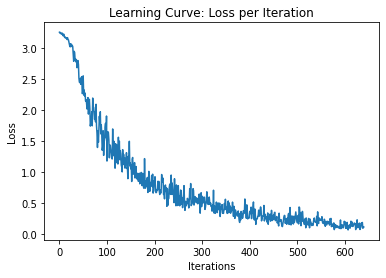

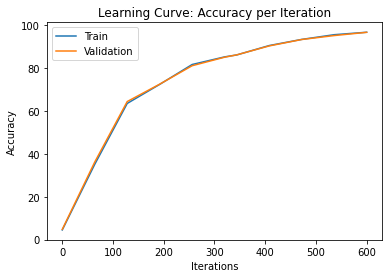

In [24]:
plot_learning_curve(iters, losses, iters_sub, train_accs, valid_accs)

We check our model performance by calculating the loss and the accuracy of the model with the test set.

Test set: Average loss: 0.478994, Accuracy: 86%


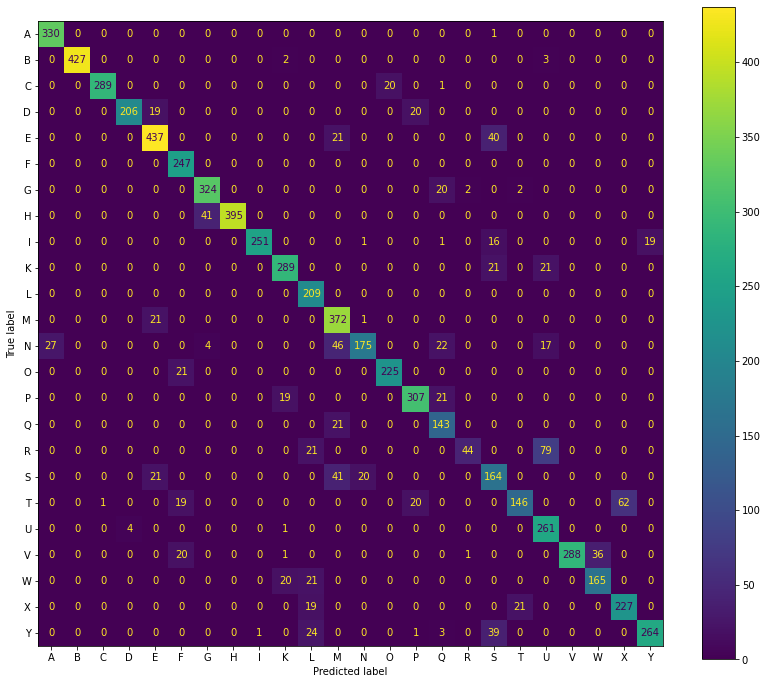

In [112]:
test_loss, test_acc, test_conf_mat = get_accuracy(model_cnn,loader=test_loader)
print("Test set: Average loss: %f, Accuracy: %.0f%%" % (test_loss,test_acc)) 
show_confusion_matrix(test_conf_mat)

Displaying some of our results:

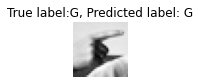

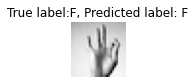

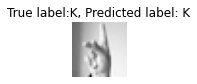

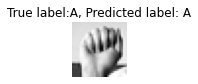

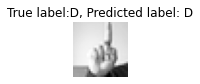

In [29]:
num_of_samples = 5
for i in range(0,num_of_samples):
  data = x_test_norm[i]
  img = np.reshape(data, (28, 28)) 
  data = torch.Tensor(data).view(-1, 28*28)
  data = data.view(-1, 1, 28, 28) 
  pred = model_cnn(data.double())
  pred = pred.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                  
  plt.figure(figsize=(2, 1))
  plt.imshow(img, cmap='Greys_r')
  plt.title(f"True label:{alphabet_dict[int(t_test[i])]}, Predicted label: {alphabet_dict[int(pred)]}")
  plt.axis('off');

Use CapsNet:

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from capsnet import CapsNet
from data_loader import Dataset
from tqdm import tqdm

USE_CUDA = True if torch.cuda.is_available() else False
BATCH_SIZE = 100
N_EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
n_features = 10
'''
Config class to determine the parameters for capsule net
'''

class Config:
    def __init__(self):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 256
        self.cnn_kernel_size = 9

        # Primary Capsule (pc)
        self.pc_num_capsules = 8
        self.pc_in_channels = 256
        self.pc_out_channels = 32
        self.pc_kernel_size = 9
        self.pc_num_routes = 32 * 6 * 6

        # Digit Capsule (dc)
        self.dc_num_capsules = 10
        self.dc_num_routes = 32 * 6 * 6
        self.dc_in_channels = 8
        self.dc_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28

def new_margin_loss(x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x ** 2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)
        print(v_c)
        print(batch_size)
        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss

def train_capsnet(model, optimizer, train_loader, epoch):
    capsule_net = model
    capsule_net.train()
    n_batch = len(list(enumerate(train_loader)))
    total_loss = 0
    for batch_id, ar in enumerate(train_loader):
        data = ar[:,1:].type(torch.double)
        target = ar[:,0].type(torch.int64)
        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        perm=torch.arange(0, 784).long()
        data = data.view(-1, 28*28)
        # data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()
        correct = sum(np.argmax(masked.data.cpu().numpy(), 1) == np.argmax(target.data.cpu().numpy(), 1))
        train_loss = loss.item()
        total_loss += train_loss
        if batch_id % 100 == 0:
            tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                epoch,
                N_EPOCHS,
                batch_id + 1,
                n_batch,
                correct / float(BATCH_SIZE),
                train_loss / float(BATCH_SIZE)
                ))
    tqdm.write('Epoch: [{}/{}], train loss: {:.6f}'.format(epoch,N_EPOCHS,total_loss / len(train_loader.dataset)))


def test_capsnet(capsule_net, test_loader, epoch):
    capsule_net.eval()
    test_loss = 0
    correct = 0
    for batch_id, (data, target) in enumerate(test_loader):

        target = torch.sparse.torch.eye(26).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        if USE_CUDA:
            data, target = data.cuda(), target.cuda()

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.item()
        correct += sum(np.argmax(masked.data.cpu().numpy(), 1) ==
                       np.argmax(target.data.cpu().numpy(), 1))

    tqdm.write(
        "Epoch: [{}/{}], test accuracy: {:.6f}, loss: {:.6f}".format(epoch, N_EPOCHS, correct / len(test_loader.dataset),
                                                                  test_loss / len(test_loader)))

In [ ]:
torch.manual_seed(1)
config = Config()

capsule_net = CapsNet(config)
capsule_net = torch.nn.DataParallel(capsule_net)
if USE_CUDA:
    capsule_net = capsule_net.cuda()
capsule_net = capsule_net.module.double()

optimizer = torch.optim.Adam(capsule_net.parameters())
capsule_net.margin_loss = new_margin_loss
for e in range(1, N_EPOCHS + 1):
    train_capsnet(capsule_net, optimizer, train_loader, e)
    test_capsnet(capsule_net, test_loader, e)
    # train(e, capsule_net)
    # test(capsule_net)